# TV Tropes
## The stories underlying stories


In [1]:
import numpy as np
#import itertools
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import re

#import sklearn.datasets as datasets
#import pandas as pd
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.externals.six import StringIO  
#from IPython.display import Image
#from IPython.display import display
#from sklearn.tree import export_graphviz
#import pydotplus

import json
import functools

import sys

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

### First, we grab data

## Original source
https://old.datahub.io/dataset/dbtropes

This is an rdf database. Since we are just looking at what movies have which tropes, we can us the database created here: https://arxiv.org/pdf/1809.10959.pdf. 
This has been imported into this project as all_films_and_their_tropes.json.


In [2]:
with open("all_films_and_their_tropes.json",'r') as f:
    movies_to_tropes = json.loads(f.read())

The form of 'data' is a dictionary from movie names to the names of their associated tropes. 

In [3]:
print(len(movies_to_tropes))
print(list(movies_to_tropes.keys())[0:10])
print(movies_to_tropes['ABeautifulMind'])
all_tropes = list(functools.reduce(lambda x,y: x.union(set(y)), movies_to_tropes.values(), set()))
all_movies = list(movies_to_tropes.keys())

print()
print(all_tropes[0])
print(len(all_tropes))

5925
['ABeautifulMind', 'ABetterTomorrow', 'ABirdersGuideToEverything', 'ABittersweetLife', 'ABoyAndHisDog', 'ABridgeTooFar', 'ABronxTale', 'ACaseOfSpringFever', 'AChristmasCarol2009', 'AChristmasStory']
['Foreshadowing', 'RuleOfPerception', 'AwardBaitSong', 'SoundtrackDissonance', 'PragmaticAdaptation', 'OffScreenTeleportation', 'ForegoneConclusion', 'ImaginaryFriend', 'OscarBait', 'TheReveal', 'IvyLeagueForEveryone', 'TakeAThirdOption', 'Hallucinations', 'AbsentMindedProfessor', 'TheLoinsSleepTonight', 'HollywoodNerd', 'ShoutOut', 'DoYouWantToCopulate', 'BrokenAce', 'TheBigBoard', 'SheIsAllGrownUp', 'PoliticallyCorrectHistory', 'AllThereIsToKnowAboutTheCryingGame', 'NotThatKindOfDoctor', 'RedScare', 'BunnyEarsLawyer', 'UnreliableNarrator', 'RoomFullOfCrazy', 'HollywoodScience', 'AdultFear', 'ForgetsToEat', 'SmartPeoplePlayChess', 'MeaningfulEcho', 'GoodWithNumbers', 'MentalStory', 'AnswerCut', 'NoMedicationForMe', 'EEqualsMCHammer', 'WritersCannotDoMath', 'EurekaMoment', 'EveryoneLov

In [4]:
#tropes_matrix = np.array([[1 if trope else 0 for trope in all _tropes] 
#                          for movie in all_movies])
def maybeSucc(x,k,y):
    if k in y:
        return x[k]+1
    return x[k]

trope_count = functools.reduce(lambda x,y: {k: maybeSucc(x,k,y) 
                                            for k in x},
                                movies_to_tropes.values(), 
                                {x:0 for x in all_tropes})
print(len(trope_count))

18270


In [5]:
def getMostCommonTropes(trope_count, number):
    common_trope_pairs = sorted(trope_count.items(), 
                                key=lambda x:-x[1])[:number]
    return list(map(lambda x:x[0], common_trope_pairs))

common_tropes = getMostCommonTropes(trope_count, 20) 
print(common_tropes)

['ShoutOut', 'ChekhovsGun', 'OhCrap', 'DeadpanSnarker', 'Jerkass', 'Foreshadowing', 'LargeHam', 'BittersweetEnding', 'TitleDrop', 'BigBad', 'MeaningfulName', 'BerserkButton', 'TheCameo', 'WhatHappenedToTheMouse', 'RunningGag', 'TooDumbToLive', 'DownerEnding', 'FanService', 'KarmaHoudini', 'GroinAttack']


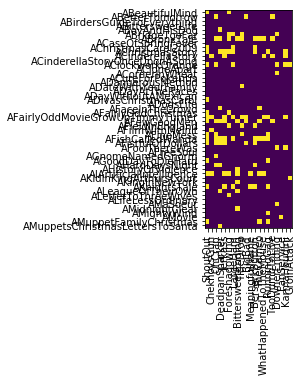

In [6]:
movie_trope_matrix = np.array(list(map(
    lambda movie: list(map(lambda trope: 1 if trope in movies_to_tropes[movie] else 0, common_tropes)), 
    movies_to_tropes)))

plt.figure()
plt.yticks(range(50), all_movies[:50])
plt.xticks(range(len(common_tropes)), common_tropes, rotation='vertical')
plt.imshow(movie_trope_matrix[:50])
#print(len(movie_trope_matrix))

## Clustering

<Container object of 18 artists>

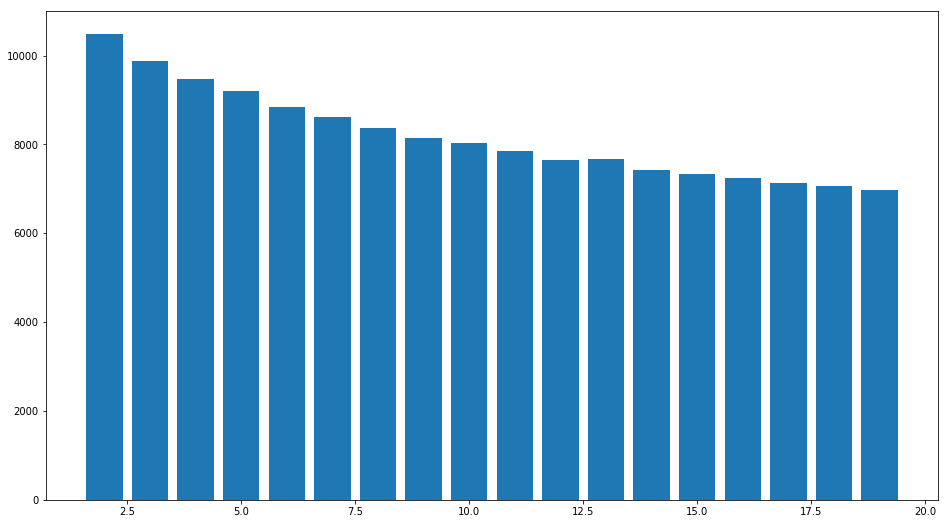

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = (16, 9)

def calc_fit_error(data,num_clusters):
    # Initializing KMeans
    kmeans = KMeans(n_clusters=num_clusters)
    # Fitting with inputs
    kmeans_fit = kmeans.fit(data)
    # Predicting the clusters
    labels = kmeans_fit.predict(data)
    # Getting the cluster centers
    # labels = animal_kmeans_fit.cluster_centers_
    return kmeans_fit.inertia_

plt.figure()
test_range = range(2,20)
plt.bar(test_range,[calc_fit_error(movie_trope_matrix,k) \
                    for k in test_range])


[3228, 587, 371, 805, 439, 495]
['ABetterTomorrow', 'ABirdersGuideToEverything', 'ABittersweetLife', 'ABoyAndHisDog', 'ACaseOfSpringFever']


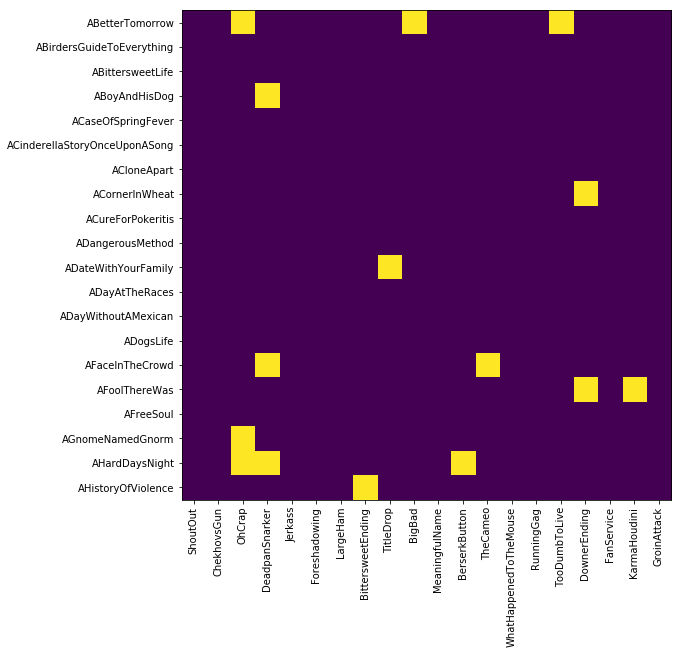

In [8]:
# Initializing KMeans
kmeans = KMeans(n_clusters=6)
# Fitting with inputs
kmeans_fit = kmeans.fit(movie_trope_matrix)
# Predicting the clusters
labels = kmeans_fit.predict(movie_trope_matrix)
# Getting the cluster centers

unique_labels = list(set(labels))
grouped_indices = [[i for i,x in enumerate(labels) if x==group] 
                   for group in unique_labels]
grouped_movie_names = [[all_movies[i] for i in group] 
                        for group in grouped_indices]
grouped_movie_matrices = [[movie_trope_matrix[i,:] for i in group]
                         for group in grouped_indices]
print(list(map(len, grouped_indices)))
print(grouped_movie_names[0][:5])

plt.figure()
plt.yticks(range(20), grouped_movie_names[0][:20])
plt.xticks(range(len(common_tropes)), common_tropes, rotation='vertical')
plt.imshow(grouped_movie_matrices[0][:20])


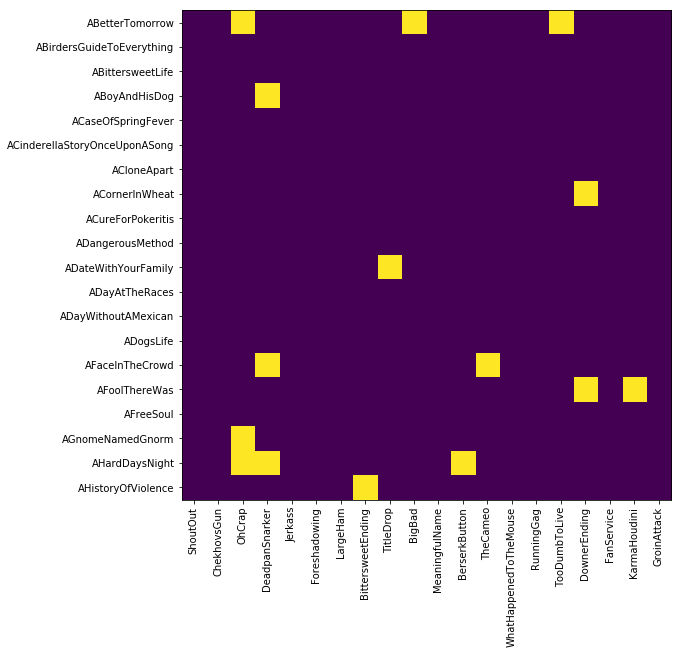

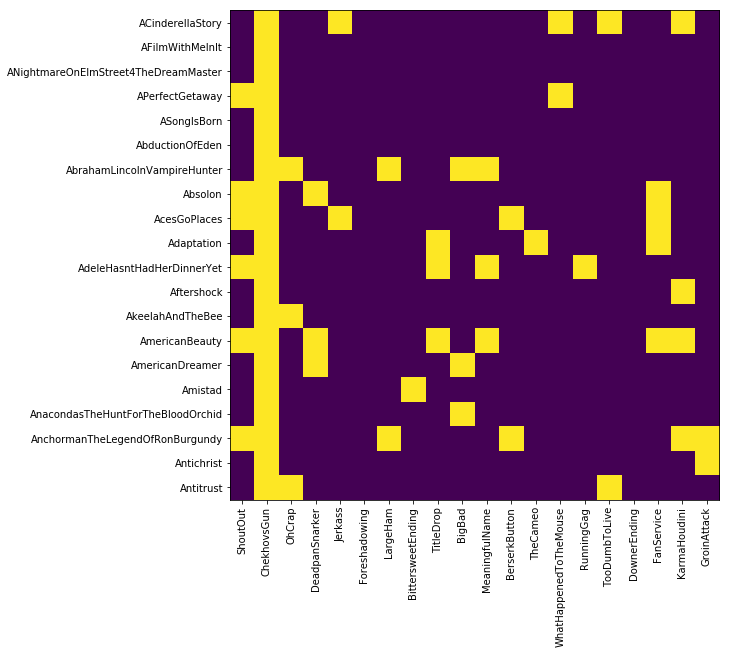

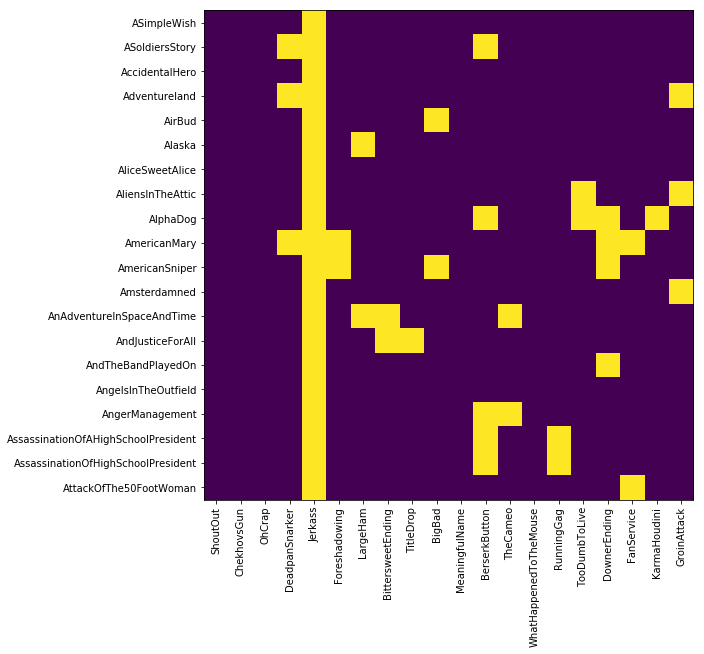

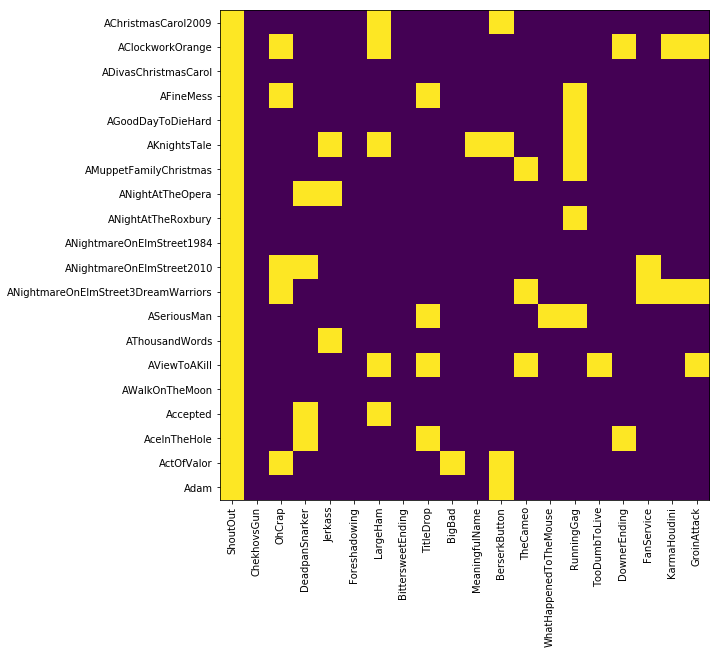

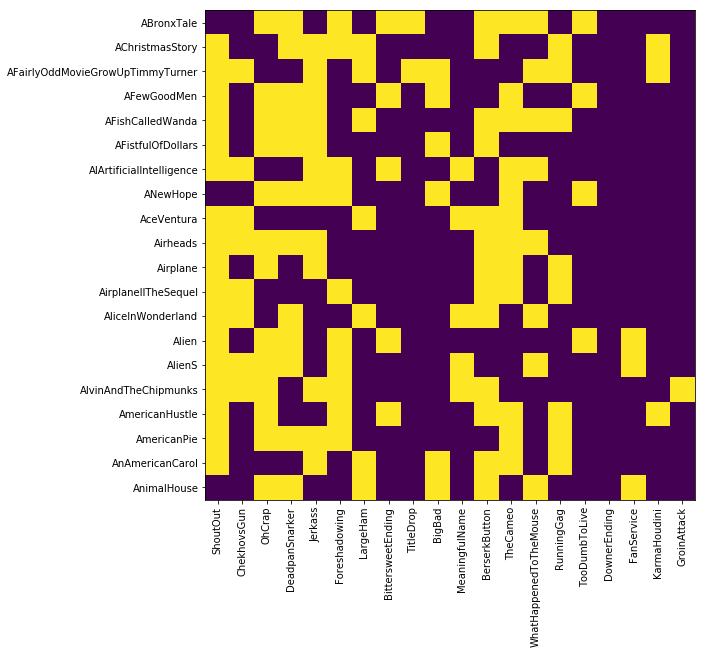

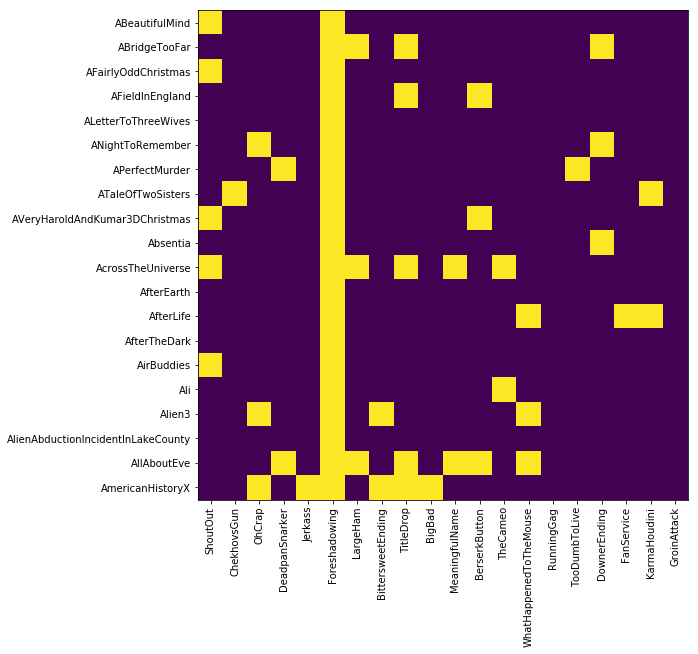

In [9]:
for k in range(len(grouped_movie_names)):
    plt.figure()
    plt.yticks(range(20), grouped_movie_names[k][:20])
    plt.xticks(range(len(common_tropes)), common_tropes, rotation='vertical')
    plt.imshow(grouped_movie_matrices[k][:20])

### Now do PCA

Steps of algo:
 1. Standardize data
 2. Obtain the eigenvecs and eigenvals from the covariance or correlation matrix or perform SVD
 3. Sort eigenvals in descending order and choose the k eigenvecs that
  corresond to the k largeset eigenvals (choose some k <=d)
 4. Construct the projection matrix W from the selected k eigenvecs
 5. Transform the original dataset X via W to obtain a k-dim feature subspace Y


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


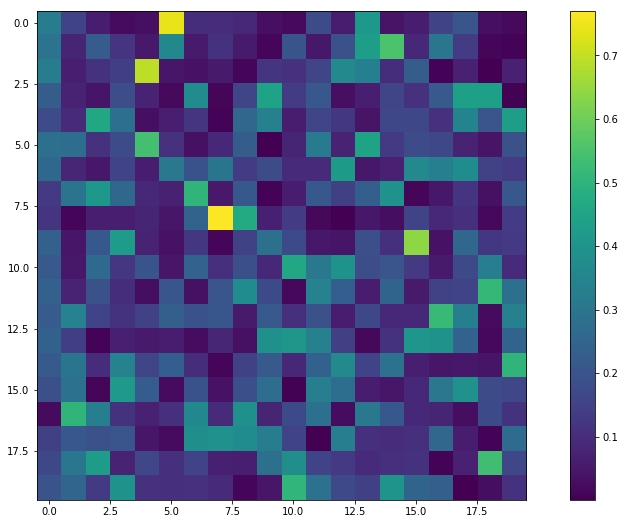

In [10]:
from sklearn.preprocessing import StandardScaler

#1. Standardize data
X_std = StandardScaler().fit_transform(movie_trope_matrix)

#2. Eigenstuff
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

plt.imshow(abs(eig_vecs))
plt.colorbar()


Eigenvalues in descending order:


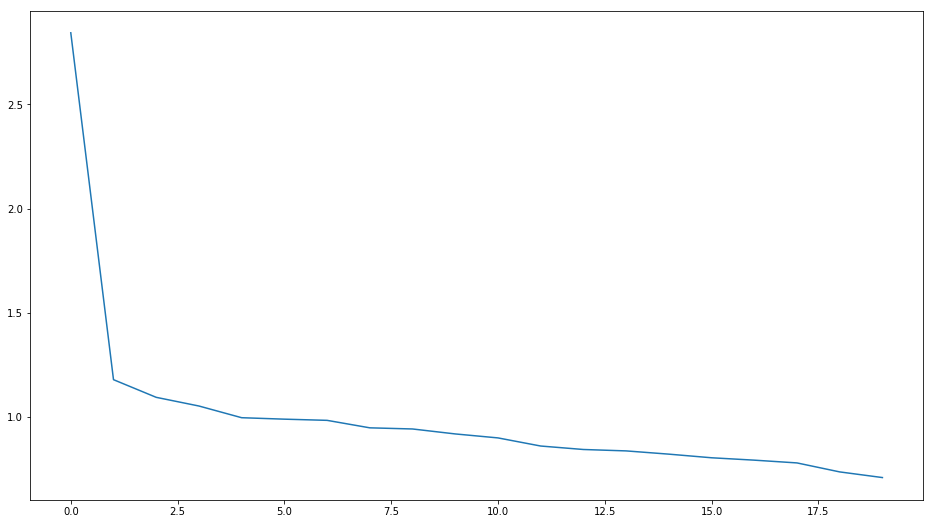

In [11]:
# 3. Choose k eigenvecs w/ largest eigenvals

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda p: -p[0])

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
plt.plot(list(map(lambda p:p[0], eig_pairs)))

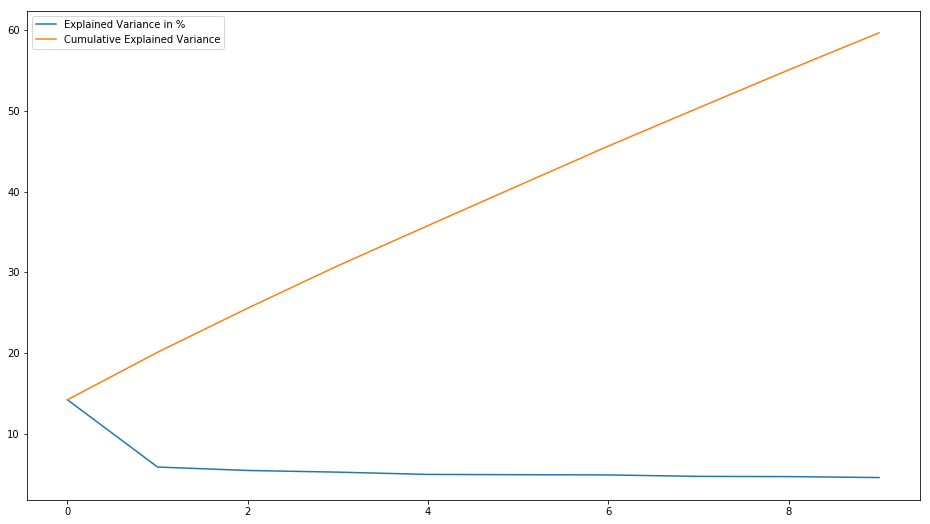

In [12]:
#4. Construct the projection matrix W from the selected k eigenvecs
#How many principal components are we going to choose for our new feature subspace?
#Pick ones with largest variance
eigenvals = eig_vals.copy()
tot = sum(eigenvals)
var_exp = [(i / tot)*100 for i in sorted(eigenvals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

num_to_show = int(len(eigenvals)/2)
plt.figure()
plt.plot(range(num_to_show), list(map(abs,var_exp[:num_to_show])), \
             label='Explained Variance in %')
plt.plot(range(num_to_show), list(map(abs,cum_var_exp[:num_to_show])), \
             label='Cumulative Explained Variance')
plt.legend(['Explained Variance in %','Cumulative Explained Variance'])

#PCA will not help too much

In [13]:
def find_peaks(x, thresh = 0.2) :
    ''' finds peaks in 1D vector.
    Inputs:
        x: input vector
        thresh: relative threshold value. Discard peak whose value is lower than (thresh * max_peak_value).
    Output:
        np.array of index values of peaks
    '''

    x0 = x[:-2]   # x
    x1 = x[1:-1]  # x shifted by 1
    x2 = x[2:]    # x shifted by 2

    peak_bools = np.logical_and(x0 < x1, x1 > x2) # where x1 is higher than surroundings
    values = x1[peak_bools]                       # list of all peak values

    # find a threshold relative to the highest peak
    th = np.max(values) * thresh
    
    # filter out values that are below th
    peak_bools = np.logical_and(peak_bools, x1 > th)

    peaks = np.nonzero( peak_bools )[0] + 1       # get indexes of peaks, shift by 1
    return peaks

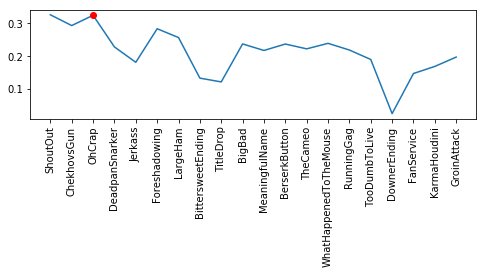

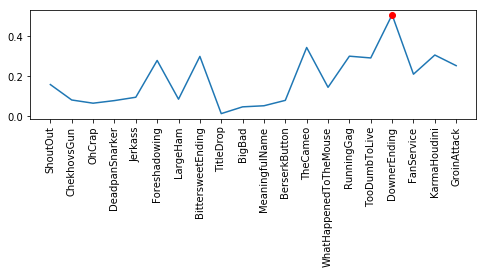

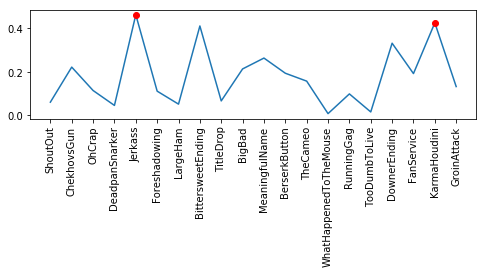

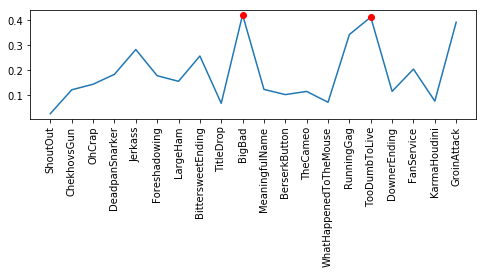

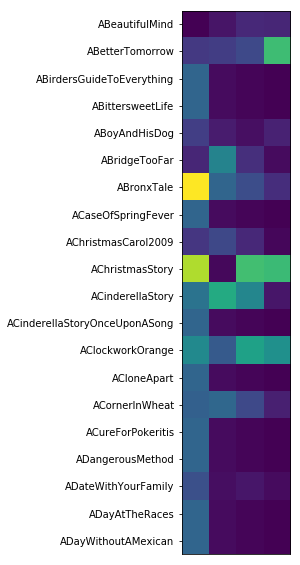

In [25]:
#@interact(target_dim=(2, 10, 1))
def plot_PCA(target_dim=3):
    matrix_w = np.hstack([p[1].reshape(-1,1) for p in eig_pairs[:target_dim]]) 
    projected_tropes_to_movies = X_std.dot(matrix_w)
    
    peaks = []
    for i in range(target_dim):
        abs_eigenvec = np.array(abs(eig_pairs[i][1]))
        plt.figure(figsize=(8,2))
        plt.plot(abs_eigenvec)
        peak_indices = find_peaks(abs_eigenvec, thresh = 0.9)
        peaks.append(peak_indices[0])
        plt.plot(peak_indices, abs_eigenvec[peak_indices], 'ro')
        plt.xticks(range(len(common_tropes)), common_tropes, rotation='vertical')

    
    plt.figure(figsize=(20,10))
    plt.yticks(range(len(all_movies[:20])),all_movies[:20])        
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.xticks(range(len(peaks)), [common_tropes[p] for p in peaks])
    plt.imshow(abs(projected_tropes_to_movies[:20]))


plot_PCA(target_dim=4)
#The x axis no longer corresponds directly to features, 
#but rather combinations of them in the form of the eigenvector

#can label most important eigenvectors with their important features


[341, 2268, 747, 1201, 930, 438]
['AChristmasStory', 'AFairlyOddMovieGrowUpTimmyTurner', 'AFewGoodMen', 'AFishCalledWanda', 'AFistfulOfDollars']


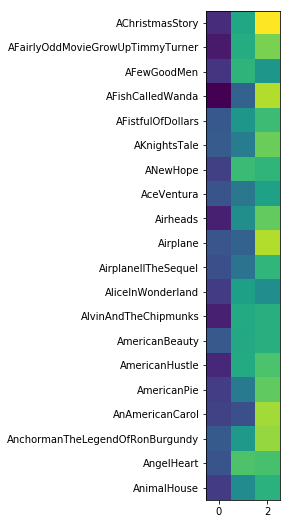

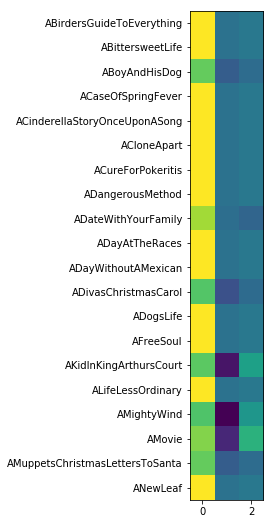

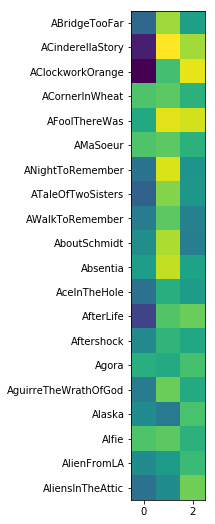

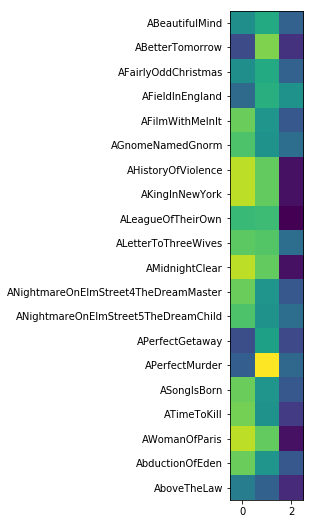

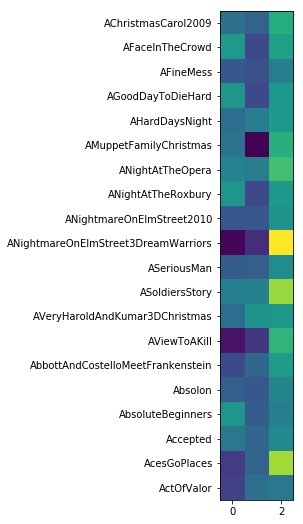

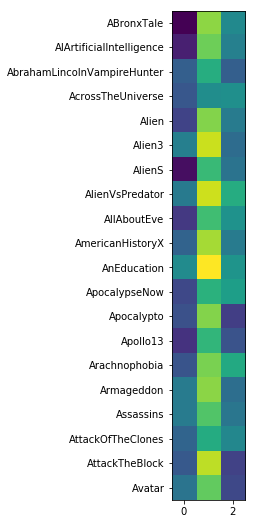

In [21]:
target_dim = 3

# Initializing KMeans
kmeans = KMeans(n_clusters=6)

matrix_w = np.hstack([p[1].reshape(-1,1) for p in eig_pairs[:target_dim]]) 
projected_tropes_to_movies = X_std.dot(matrix_w)

# Fitting with inputs
kmeans_fit = kmeans.fit(projected_tropes_to_movies)
# Predicting the clusters
labels = kmeans_fit.predict(projected_tropes_to_movies)
# Getting the cluster centers


unique_labels = list(set(labels))
grouped_indices = [[i for i,x in enumerate(labels) if x==group] 
                   for group in unique_labels]
grouped_movie_names = [[all_movies[i] for i in group] 
                        for group in grouped_indices]
grouped_movie_matrices = [[projected_tropes_to_movies[i,:] for i in group]
                         for group in grouped_indices]
print(list(map(len, grouped_indices)))
print(grouped_movie_names[0][:5])

#plt.figure()
#plt.yticks(range(20), grouped_movie_names[0][:20])
#plt.xticks(range(len(common_tropes)), common_tropes, rotation='vertical')
for i in range(len(grouped_movie_matrices)):
    plt.figure()
    plt.yticks(range(20), grouped_movie_names[i][:20])
    plt.imshow(grouped_movie_matrices[i][:20])

In [ ]:
#next GMM or matrix factorization